In [81]:
#Regresion Stock Prices  with Keras LTSM Network

from pandas import read_csv
from pandas import datetime
from math import sqrt
from matplotlib import pyplot
import numpy as np
import pandas as pd
from pandas_datareader import data as wb
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU,SimpleRNN

from math import sqrt
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
import library as mio



In [82]:
# reduced list only the most correlated
indices_list_Complete = ["SPY","^IXIC", "^DJI", "^GDAXI", "^FTSE","^FCHI", "^N225","^HSI", "^AXJO","ORB", "EUR","AUD","GBP","JPY", "SILVER", "GOLD", "WT1010"] # reduced list only the most correlated
indice_target=["^GSPC"]

In [83]:
start_date = "2003-01-01" # Start day of Series
end_date = "2017-01-01"	  # Final day of series
dates = pd.date_range(start_date, end_date)  # date range as index

In [84]:
df_index = mio.get_data(indices_list_Complete, dates)
df_target= mio.get_data(indice_target, dates)

In [85]:
df_index.fillna(method='bfill', inplace=True)
df_target.fillna(method='bfill', inplace=True)

In [86]:
df_index.tail()

,SPY,^IXIC,^DJI,^GDAXI,^FTSE,^FCHI,^N225,^HSI,^AXJO,ORB,EUR,AUD,GBP,JPY,SILVER,GOLD,WT1010
2016-12-23,224.732324,5462.689941,19933.810547,11449.929688,7068.200195,4839.680176,19403.060547,21574.759766,5627.899902,51.74,0.957179,1.394655,0.814821,117.185667,15.74,1131.00,0.25
2016-12-27,225.289896,5487.439941,19945.039062,11472.240234,7106.100098,4848.279785,19403.060547,21754.740234,5685.000000,52.25,0.956361,1.391288,0.815262,117.457200,15.85,1139.75,0.21
2016-12-28,223.427985,5438.560059,19833.679688,11474.990234,7106.100098,4848.009766,19401.720703,21754.740234,5685.000000,53.39,0.963017,1.393879,0.817868,117.543337,15.85,1139.75,0.19
2016-12-29,223.378214,5432.089844,19819.779297,11451.049805,7120.299805,4838.470215,19145.140625,21790.910156,5699.100098,53.46,0.954902,1.387659,0.817942,116.505533,16.06,1146.80,0.17
2016-12-30,222.561759,5383.120117,19762.599609,11481.059570,7142.799805,4862.310059,19114.369141,22000.560547,5665.799805,53.30,0.948191,1.385629,0.810056,116.637500,16.24,1159.10,0.19


In [87]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

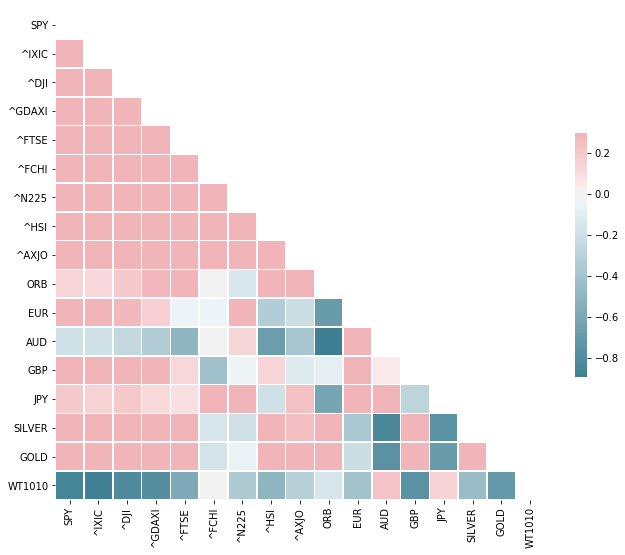

In [88]:
corr = df_index.corr()
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


In [89]:
df_target.tail()

,^GSPC
2016-12-23,2263.790039
2016-12-27,2268.879883
2016-12-28,2249.919922
2016-12-29,2249.260010
2016-12-30,2238.830078


In [90]:
def shift_minus(df, list_s, n):
    for symbol in list_s:
        M = pd.Series(df[symbol].shift(-1), name = str(symbol)+"-" + str(n))
        df=df.join(M)
    return df

In [91]:
df_target_2=shift_minus(df_index, indices_list_Complete,1)

In [92]:
df_target_2.drop(df_target_2.columns[[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]], axis=1, inplace=True)

In [93]:
df_final=df_target.join(df_target_2)
M = pd.Series(df_target["^GSPC"].shift(-1), name = "^GSPC-" + str(1))
df_final = df_final.join(M)

In [94]:
df_final = df_final[:-1]


In [95]:
indexs=df_final.index

In [96]:
values = df_final.values
train_size = int(len(values) * 0.66)
train, test = values[0:train_size], values[train_size:len(values)]
print('Observations: %d' % (len(values)))
print('Training Observations: %d' % (len(train)))
print('Testing Observations: %d' % (len(test)))

Observations: 3524
Training Observations: 2325
Testing Observations: 1199


In [97]:
df_test=df_final[train_size:len(values)]

In [98]:
indexs=df_test.index

In [99]:
indexs

DatetimeIndex(['2012-03-27', '2012-03-28', '2012-03-29', '2012-03-30',
               '2012-04-02', '2012-04-03', '2012-04-04', '2012-04-05',
               '2012-04-09', '2012-04-10',
               ...
               '2016-12-15', '2016-12-16', '2016-12-19', '2016-12-20',
               '2016-12-21', '2016-12-22', '2016-12-23', '2016-12-27',
               '2016-12-28', '2016-12-29'],
              dtype='datetime64[ns]', length=1199, freq=None)

In [100]:
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]



In [101]:
test_y

array([1405.540039, 1403.280029, 1408.469971, ..., 2249.919922,
       2249.26001 , 2238.830078])

In [102]:
# normalize features
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler(feature_range=(-1, 1))
train_XS = min_max_scaler.fit_transform(train_X)
#train_yS = min_max_scaler.fit_transform(train_y)
test_XS = min_max_scaler.fit_transform(test_X)
#test_yS = min_max_scaler.fit_transform(test_y)

In [103]:
max_value = train_y.max()
min_value = train_y.min()
train_yS= (train_y - min_value) / (max_value - min_value)

In [104]:
max_value2 = test_y.max()
min_value2 = test_y.min()
test_yS= (test_y - min_value2) / (max_value2 - min_value2)

In [105]:
test_yS

array([0.12831093, 0.12603655, 0.1312595 , ..., 0.9780613 , 0.97739719,
       0.96690092])

In [106]:
train_XS = train_XS.reshape((train_XS.shape[0], 1, train_XS.shape[1]))
test_XS = test_XS.reshape((test_XS.shape[0], 1, test_XS.shape[1]))
print(train_XS.shape, train_yS.shape, test_XS.shape, test_yS.shape)

(2325, 1, 18) (2325,) (1199, 1, 18) (1199,)


In [107]:

def reset_weights(model):
    session = K.get_session()
    for layer in model.layers:
        if isinstance(layer, Dense):
            old = layer.get_weights()
            layer.W.initializer.run(session=session)
            layer.b.initializer.run(session=session)
            print(np.array_equal(old, layer.get_weights())," after initializer run")
        else:
            print(layer, "not reinitialized")


In [108]:
# design network
model = Sequential()
reset_weights(model)

model.add(SimpleRNN(32, activation='softmax',input_shape=(train_XS.shape[1], train_XS.shape[2])))# RNN Cell
#model.add(LSTM(32, input_shape=(train_XS.shape[1], train_XS.shape[2])))# LSTM Cell
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam', metrics=['mse', 'mae'])

In [109]:
history = model.fit(train_XS, train_yS, epochs=250, batch_size=16, validation_data=(test_XS, test_yS), verbose=2, shuffle=False)

Train on 2325 samples, validate on 1199 samples
Epoch 1/250
 - 1s - loss: 0.1298 - mean_squared_error: 0.1298 - mean_absolute_error: 0.3209 - val_loss: 0.0941 - val_mean_squared_error: 0.0941 - val_mean_absolute_error: 0.2712
Epoch 2/250
 - 0s - loss: 0.0376 - mean_squared_error: 0.0376 - mean_absolute_error: 0.1616 - val_loss: 0.0562 - val_mean_squared_error: 0.0562 - val_mean_absolute_error: 0.2112
Epoch 3/250
 - 0s - loss: 0.0183 - mean_squared_error: 0.0183 - mean_absolute_error: 0.1086 - val_loss: 0.0417 - val_mean_squared_error: 0.0417 - val_mean_absolute_error: 0.1831
Epoch 4/250
 - 0s - loss: 0.0095 - mean_squared_error: 0.0095 - mean_absolute_error: 0.0766 - val_loss: 0.0318 - val_mean_squared_error: 0.0318 - val_mean_absolute_error: 0.1610
Epoch 5/250
 - 0s - loss: 0.0052 - mean_squared_error: 0.0052 - mean_absolute_error: 0.0526 - val_loss: 0.0250 - val_mean_squared_error: 0.0250 - val_mean_absolute_error: 0.1434
Epoch 6/250
 - 0s - loss: 0.0034 - mean_squared_error: 0.0034 

Epoch 46/250
 - 0s - loss: 8.2499e-05 - mean_squared_error: 8.2499e-05 - mean_absolute_error: 0.0069 - val_loss: 0.0025 - val_mean_squared_error: 0.0025 - val_mean_absolute_error: 0.0383
Epoch 47/250
 - 0s - loss: 8.0865e-05 - mean_squared_error: 8.0865e-05 - mean_absolute_error: 0.0068 - val_loss: 0.0025 - val_mean_squared_error: 0.0025 - val_mean_absolute_error: 0.0379
Epoch 48/250
 - 0s - loss: 7.9625e-05 - mean_squared_error: 7.9625e-05 - mean_absolute_error: 0.0067 - val_loss: 0.0024 - val_mean_squared_error: 0.0024 - val_mean_absolute_error: 0.0375
Epoch 49/250
 - 0s - loss: 7.8747e-05 - mean_squared_error: 7.8747e-05 - mean_absolute_error: 0.0067 - val_loss: 0.0024 - val_mean_squared_error: 0.0024 - val_mean_absolute_error: 0.0371
Epoch 50/250
 - 0s - loss: 7.8203e-05 - mean_squared_error: 7.8203e-05 - mean_absolute_error: 0.0067 - val_loss: 0.0023 - val_mean_squared_error: 0.0023 - val_mean_absolute_error: 0.0367
Epoch 51/250
 - 0s - loss: 7.7961e-05 - mean_squared_error: 7.796

Epoch 90/250
 - 0s - loss: 5.7797e-04 - mean_squared_error: 5.7797e-04 - mean_absolute_error: 0.0167 - val_loss: 0.0012 - val_mean_squared_error: 0.0012 - val_mean_absolute_error: 0.0289
Epoch 91/250
 - 1s - loss: 3.7123e-04 - mean_squared_error: 3.7123e-04 - mean_absolute_error: 0.0141 - val_loss: 8.7443e-04 - val_mean_squared_error: 8.7443e-04 - val_mean_absolute_error: 0.0249
Epoch 92/250
 - 0s - loss: 3.9526e-04 - mean_squared_error: 3.9526e-04 - mean_absolute_error: 0.0155 - val_loss: 0.0012 - val_mean_squared_error: 0.0012 - val_mean_absolute_error: 0.0284
Epoch 93/250
 - 0s - loss: 5.2178e-04 - mean_squared_error: 5.2178e-04 - mean_absolute_error: 0.0169 - val_loss: 0.0013 - val_mean_squared_error: 0.0013 - val_mean_absolute_error: 0.0292
Epoch 94/250
 - 0s - loss: 3.9266e-04 - mean_squared_error: 3.9266e-04 - mean_absolute_error: 0.0146 - val_loss: 0.0017 - val_mean_squared_error: 0.0017 - val_mean_absolute_error: 0.0329
Epoch 95/250
 - 0s - loss: 2.5040e-04 - mean_squared_erro

Epoch 134/250
 - 0s - loss: 1.7772e-04 - mean_squared_error: 1.7772e-04 - mean_absolute_error: 0.0101 - val_loss: 0.0024 - val_mean_squared_error: 0.0024 - val_mean_absolute_error: 0.0381
Epoch 135/250
 - 0s - loss: 1.2036e-04 - mean_squared_error: 1.2036e-04 - mean_absolute_error: 0.0082 - val_loss: 0.0020 - val_mean_squared_error: 0.0020 - val_mean_absolute_error: 0.0341
Epoch 136/250
 - 0s - loss: 1.0058e-04 - mean_squared_error: 1.0058e-04 - mean_absolute_error: 0.0076 - val_loss: 9.0977e-04 - val_mean_squared_error: 9.0977e-04 - val_mean_absolute_error: 0.0235
Epoch 137/250
 - 0s - loss: 2.2807e-04 - mean_squared_error: 2.2807e-04 - mean_absolute_error: 0.0100 - val_loss: 0.0018 - val_mean_squared_error: 0.0018 - val_mean_absolute_error: 0.0383
Epoch 138/250
 - 0s - loss: 2.0305e-04 - mean_squared_error: 2.0305e-04 - mean_absolute_error: 0.0099 - val_loss: 0.0023 - val_mean_squared_error: 0.0023 - val_mean_absolute_error: 0.0449
Epoch 139/250
 - 1s - loss: 1.1703e-04 - mean_square

Epoch 178/250
 - 0s - loss: 2.7203e-04 - mean_squared_error: 2.7203e-04 - mean_absolute_error: 0.0118 - val_loss: 0.0026 - val_mean_squared_error: 0.0026 - val_mean_absolute_error: 0.0382
Epoch 179/250
 - 0s - loss: 3.3050e-04 - mean_squared_error: 3.3050e-04 - mean_absolute_error: 0.0130 - val_loss: 0.0036 - val_mean_squared_error: 0.0036 - val_mean_absolute_error: 0.0468
Epoch 180/250
 - 1s - loss: 1.6805e-04 - mean_squared_error: 1.6805e-04 - mean_absolute_error: 0.0099 - val_loss: 0.0011 - val_mean_squared_error: 0.0011 - val_mean_absolute_error: 0.0253
Epoch 181/250
 - 0s - loss: 2.9883e-04 - mean_squared_error: 2.9883e-04 - mean_absolute_error: 0.0131 - val_loss: 0.0021 - val_mean_squared_error: 0.0021 - val_mean_absolute_error: 0.0386
Epoch 182/250
 - 0s - loss: 3.3609e-04 - mean_squared_error: 3.3609e-04 - mean_absolute_error: 0.0135 - val_loss: 0.0044 - val_mean_squared_error: 0.0044 - val_mean_absolute_error: 0.0603
Epoch 183/250
 - 0s - loss: 2.3415e-04 - mean_squared_error:

Epoch 222/250
 - 0s - loss: 2.1296e-04 - mean_squared_error: 2.1296e-04 - mean_absolute_error: 0.0103 - val_loss: 0.0019 - val_mean_squared_error: 0.0019 - val_mean_absolute_error: 0.0321
Epoch 223/250
 - 1s - loss: 2.0305e-04 - mean_squared_error: 2.0305e-04 - mean_absolute_error: 0.0104 - val_loss: 0.0022 - val_mean_squared_error: 0.0022 - val_mean_absolute_error: 0.0349
Epoch 224/250
 - 0s - loss: 1.4589e-04 - mean_squared_error: 1.4589e-04 - mean_absolute_error: 0.0094 - val_loss: 8.6017e-04 - val_mean_squared_error: 8.6017e-04 - val_mean_absolute_error: 0.0228
Epoch 225/250
 - 0s - loss: 2.5495e-04 - mean_squared_error: 2.5495e-04 - mean_absolute_error: 0.0120 - val_loss: 0.0028 - val_mean_squared_error: 0.0028 - val_mean_absolute_error: 0.0453
Epoch 226/250
 - 0s - loss: 2.3248e-04 - mean_squared_error: 2.3248e-04 - mean_absolute_error: 0.0121 - val_loss: 0.0045 - val_mean_squared_error: 0.0045 - val_mean_absolute_error: 0.0613
Epoch 227/250
 - 0s - loss: 1.9005e-04 - mean_square

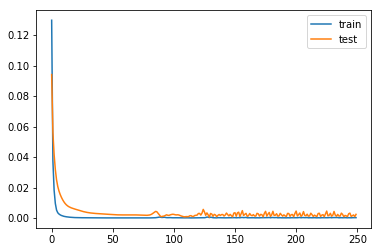

In [110]:
from matplotlib import pyplot
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show() 

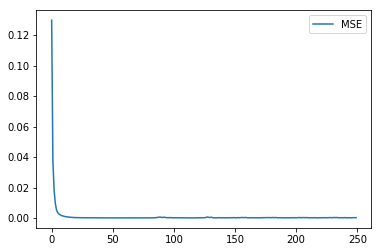

In [111]:
# plot metrics
pyplot.plot(history.history['mean_squared_error'], label='MSE')
#pyplot.plot(history.history['mean_absolute_error'],label='MAE')
pyplot.legend()
pyplot.show()

In [112]:
# make a prediction
yhat = model.predict(test_XS)
test_XS = test_XS.reshape((test_XS.shape[0], test_XS.shape[2]))

In [113]:
# invert scaling for forecast
max_value2 = test_y.max()
min_value2 = test_y.min()
inv_yhat= (yhat * (max_value2 - min_value2))+min_value2


In [114]:
inv_yhat

array([[1438.9482],
       [1434.7394],
       [1440.0208],
       ...,
       [2239.6985],
       [2236.9336],
       [2235.0137]], dtype=float32)

In [115]:
from math import sqrt
from sklearn.metrics import mean_squared_error
import matplotlib
# calculate RMSE
rmse = sqrt(mean_squared_error(test_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 48.754


In [116]:
lowerx=inv_yhat-(2*rmse)
upperx=inv_yhat+(2*rmse)

In [117]:
inv_yhat

array([[1438.9482],
       [1434.7394],
       [1440.0208],
       ...,
       [2239.6985],
       [2236.9336],
       [2235.0137]], dtype=float32)

In [118]:
#upper=np.array([sp500[['Upper band']]["2017-12-01":].values]).reshape(len(sp500a),)
upper=upperx.reshape(len(inv_yhat),)
lower=lowerx.reshape(len(inv_yhat),)

In [119]:
upper.shape

(1199,)

Test RMSE: 48.754
Test R2: 0.967


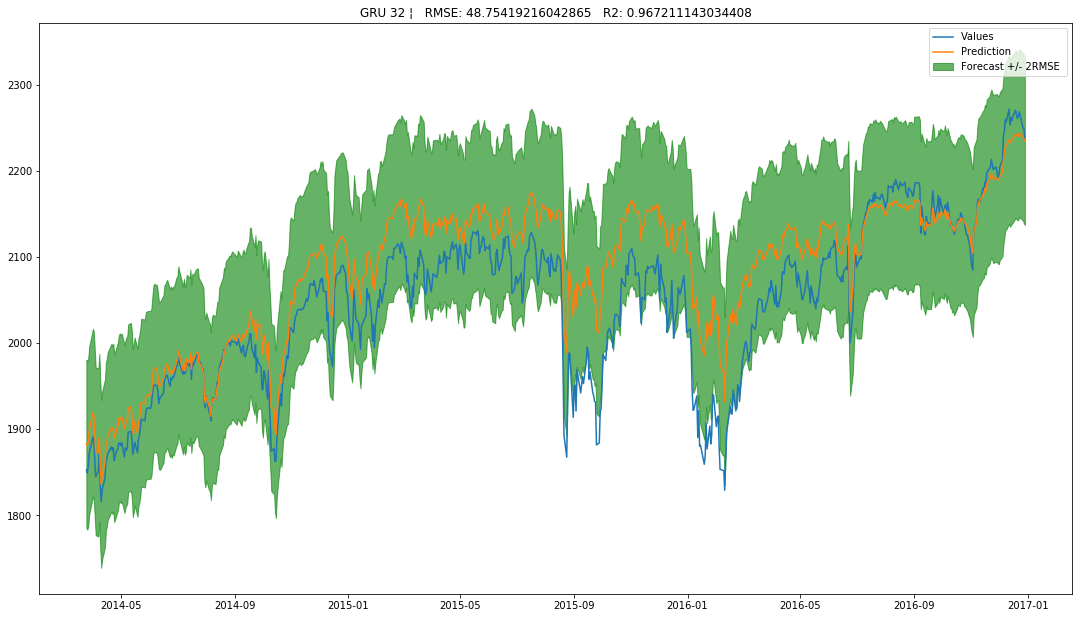

In [121]:
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import matplotlib
# calculate RMSE
rmse = sqrt(mean_squared_error(test_y, inv_yhat))
r2=r2_score(test_y,inv_yhat)
print('Test RMSE: %.3f' % rmse)
print('Test R2: %.3f' % r2)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)
fig.set_size_inches(18.5, 10.5, forward=True)
pyplot.plot(indexs[500:],test_y[500:], label='Values')
pyplot.plot(indexs[500:],inv_yhat[500:], label='Prediction')
pyplot.fill_between(indexs[500:],upper[500:],lower[500:], color='g', alpha=0.6, label='Forecast +/- 2RMSE ')
pyplot.legend()
pyplot.title("GRU 32 ¦   RMSE: " +str(rmse)+ "   R2: " + str(r2))
pyplot.show()